In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import pytorch_lightning as pl
from torchvision.datasets import ImageFolder
import torchmetrics

import numpy as np
import pandas as pd
import math
import glob
import os
import cv2
import kornia
import collections

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger

import matplotlib.pyplot as plt

# Utils

In [2]:
def show_img(x, dpi=50):
    plt.figure(dpi=dpi)
    plt.imshow(x.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Data

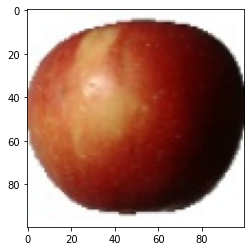

In [3]:
example_path = 'fruits-360_dataset/fruits-360/Training/Apple Braeburn/0_100.jpg'
img_bgr = cv2.imread(example_path)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)

In [4]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()])

train_dataset = ImageFolder('fruits-360_dataset/fruits-360/Training', transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, 
                              batch_size=batch_size, num_workers=4)

val_dataset = ImageFolder('fruits-360_dataset/fruits-360/Test', transform=transform)
val_dataloader = DataLoader(val_dataset, shuffle=True, 
                            batch_size=batch_size, num_workers=4)

class_names = train_dataset.classes

len(train_dataset), len(val_dataset)

(67692, 22688)

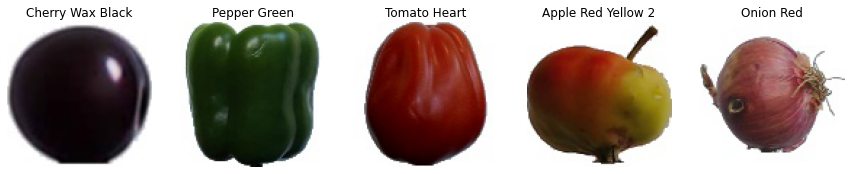

In [5]:
example_batch = next(iter(train_dataloader))

fig, ax = plt.subplots(1, 5, figsize=(15, 10))
for i, img_idx in enumerate(np.random.randint(batch_size, size=5)):
    ax[i].imshow(torch.clamp((example_batch[0][img_idx]), 0, 1).permute(1, 2, 0))
    ax[i].set_title(class_names[example_batch[1][img_idx].item()])
    ax[i].axis('off')
plt.show()

# Hue augmentation (new)

In [6]:
#Both rgb2hsv and hsv2rgb take images in a mini-batch of images (NCHW format) as input. 
#The range of H (hue) is from 0 to 360 (the outside of the range loops). The range of RGB and SV is 0 to 1.

def rgb2hsv(input, epsilon=1e-10):
    assert(input.shape[1] == 3)

    r, g, b = input[:, 0], input[:, 1], input[:, 2]
    max_rgb, argmax_rgb = input.max(1)
    min_rgb, argmin_rgb = input.min(1)

    max_min = max_rgb - min_rgb + epsilon

    h1 = 60.0 * (g - r) / max_min + 60.0
    h2 = 60.0 * (b - g) / max_min + 180.0
    h3 = 60.0 * (r - b) / max_min + 300.0

    h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
    s = max_min / (max_rgb + epsilon)
    v = max_rgb

    return torch.stack((h, s, v), dim=1)

def hsv2rgb(input):
    assert(input.shape[1] == 3)

    h, s, v = input[:, 0], input[:, 1], input[:, 2]
    h_ = (h - torch.floor(h / 360) * 360) / 60
    c = s * v
    x = c * (1 - torch.abs(torch.fmod(h_, 2) - 1))

    zero = torch.zeros_like(c)
    y = torch.stack((
        torch.stack((c, x, zero), dim=1),
        torch.stack((x, c, zero), dim=1),
        torch.stack((zero, c, x), dim=1),
        torch.stack((zero, x, c), dim=1),
        torch.stack((x, zero, c), dim=1),
        torch.stack((c, zero, x), dim=1),
    ), dim=0)

    index = torch.repeat_interleave(torch.floor(h_).unsqueeze(1), 3, dim=1).unsqueeze(0).to(torch.long)
    rgb = (y.gather(dim=0, index=index).squeeze(0) + (v - c).unsqueeze(1))
    return rgb

In [7]:
#дифференцируемая аугментация оттенка
class MyHueAug(nn.Module):
    """
    Differetiable hue adjustment
    """
    def __init__(self, start):
        super().__init__()
        self.log_lims = nn.Parameter(torch.tensor([-float(start), float(start)]))
        
    @property
    def lims(self):
        return torch.sigmoid(self.log_lims) * 2 - 1

    def forward(self, x):
        self.bs, self.channels, self.height, self.width = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        x = rgb2hsv(x)
        hue_change_value = torch.rand(self.bs)*(self.lims[1] - self.lims[0]) + self.lims[0]
        hue_change_value = hue_change_value * 180
        hue_change_tensor = hue_change_value.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        hue_change_tensor = hue_change_tensor.expand(self.bs, 1, self.height, self.width)
        hue_channel = x[:, 0]
        new_hue_channel = ((((hue_channel + hue_change_tensor[:, 0]) / 360) % 1) * 360)
        x[:, 0] = new_hue_channel
        x = hsv2rgb(x)
        
        return x
    
my_hue_aug = MyHueAug(2)

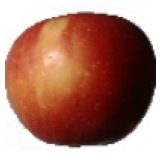

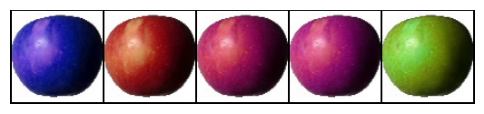

In [8]:
with torch.no_grad():
    x = train_dataset[0][0]
    x_aug = my_hue_aug(x[None, ...].expand(5, 3, -1, -1))
show_img(x)
show_img(torchvision.utils.make_grid(x_aug), dpi=100)

# Brightness augmentation

In [9]:
# дифференцируемая аугментация яркости
class BrightnessAug(nn.Module):
    """
    Differetiable brightness adjustment
    """
    def __init__(self, start):
        super().__init__()
        self.log_lims = nn.Parameter(torch.tensor([-float(start), float(start)]))
    
    @property
    def lims(self):
        return torch.sigmoid(self.log_lims) * 2 - 1

    def forward(self, x):
        bs = x.shape[0]
        brightness_change = torch.rand(bs, device=x.device) * (self.lims[1] - self.lims[0]) + self.lims[0]
        brightness_change = brightness_change[:, None, None, None]

        return torch.clamp(x + brightness_change, 0, 1)
    
brightness_aug = BrightnessAug(2)

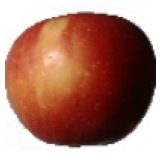

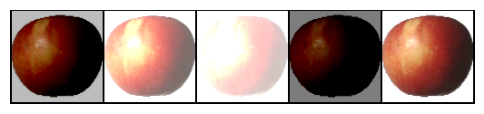

In [10]:
with torch.no_grad():
    x = train_dataset[0][0]
    x_aug = brightness_aug(x[None, ...].expand(5, 3, -1, -1))
show_img(x)
show_img(torchvision.utils.make_grid(x_aug), dpi=100)

# Model

In [11]:
class CNN_XS(nn.Module):
    def __init__(self):
        super(CNN_XS, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 10 * 10, 600)
        self.bn4 = nn.BatchNorm1d(600)
        self.fc2 = nn.Linear(600, 131)
        
        self.dropout = nn.Dropout()


    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [12]:
my_hue_aug = MyHueAug(1)

brightness_aug = BrightnessAug(0.5)

In [13]:
use_augerino = True #диапазон проверки [False, True]
aug = brightness_aug #диапазон проверки [hue_aug, my_hue_aug, brightness_aug]

epochs = 3
lr = 0.01 #у нас не предобученная модель, поэтому 3e-4 вряд ли подойдет

aug_lr = 0.01 #[диапазон проверки 0, 0.01, 0.1]
aug_reg = 1 #[диапазон проверки 0 (вообще без регуляризации), 0.01, 0.1]
#надо регулировать, если несопоставимо собственно с функцией потерь

n_copies = 4 #TTA

#потенциально - тип вычисления бонуса, норма или квадрат

In [14]:
#уникальное имя эксперимента
name = str('augerino-') + str(use_augerino) + '_' + str('augtype-') + str(aug)[:7] + '_' \
+ str('epochs-') + str(epochs) + '_' + str('lr-') + str(lr) + '_' + str('auglr-') + str(aug_lr) \
+ '_' + str('augreg-') + str(aug_reg) + '_' + str('ncopies-') + str(n_copies)
name

'augerino-True_augtype-Brightn_epochs-3_lr-0.01_auglr-0.01_augreg-1_ncopies-4'

In [15]:
class WrapperModel(nn.Module):
    def __init__(self, model, aug, n_copies):
        super().__init__()
        self.aug = aug
        self.model = model
        self.n_copies = n_copies
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        self.eps = 1e-6
    
    def forward(self, x):
        
        if self.training:
            if not use_augerino:
                aug_x = x
            else:
                aug_x = self.aug(x)
            
            aug_x = (aug_x - self.mean) / self.std
            out = self.model(aug_x)  # b, n_class
            out = torch.log_softmax(out, dim=1)  # b, n_class
        
        else:
            if not use_augerino:
                out = self.model(x)
                out = torch.log_softmax(out, dim=1)
            else:
                b, c, h, w = x.shape
                k = self.n_copies
                x = x.view(b, 1, c, h, w)
                aug_x = x.expand(b, k, c, h, w).contiguous().view(b * k, c, h, w).clone()         
                aug_x = self.aug(aug_x).view(b, k, c, h, w)
                aug_x = torch.cat([x, aug_x], dim=1)  # b, k + 1, c, h, w
                aug_x = aug_x.view(b * (k + 1), c, h, w)
                aug_x = (aug_x - self.mean) / self.std
                out = self.model(aug_x)  # b * (k + 1), n_class
                out = torch.log_softmax(out, dim=1)  # b * (k + 1), n_class
                out = out.view(b, k + 1, out.shape[-1]).mean(dim=1)  # b, n_class
                # can result in probs that do not sum into 1, need additional normalization
                probs = torch.exp(out)
                probs = probs / (torch.sum(probs, dim=1, keepdim=True) + self.eps)
                out = torch.log(probs + self.eps)

        return out

In [16]:
#альтернативно - для предобученной модели
#base_model = models.resnet18(pretrained=True)
#base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=131)

#torch.nn.init.zeros_(base_model.fc.bias)
#torch.nn.init.zeros_(base_model.fc.weight)

In [17]:
base_model = CNN_XS()
model = WrapperModel(base_model, aug=aug, n_copies=n_copies)
base_loss_fn = nn.NLLLoss()

In [18]:
def aug_reg_loss_fn(inputs, labels, model):
    
    base_loss = base_loss_fn(inputs, labels)
    aug_bonus = 0
    if aug_reg > 0 and use_augerino: #без augerino превращается в обычную функцию потерь
        lims = model.aug.lims
        m = lims[0]
        n = lims[1]
        aug_bonus_ = n - m
        aug_bonus = aug_bonus_ * aug_reg
        
    return base_loss + (aug_reg - aug_bonus), aug_bonus #так как бонус органичен 1 * aug_reg

In [19]:
class PLModel(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.train_epoch_accuracy_running = []
        self.train_epoch_accuracy = []

    def forward(self, x):
        #defines prediction/inference actions
        return torch.exp(self.model(x))

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # it is independent of forward
        x, y = batch[0], batch[1] 
        neg_logs = self.model(x)
        loss, aug_bonus = aug_reg_loss_fn(neg_logs, y, self.model)
        probs = torch.exp(neg_logs)
        train_accuracy = self.train_accuracy(probs, y)
        
        preds = torch.argmax(probs, dim=1)
        custom_train_batch_accuracy = (preds == y).float().mean()
        self.train_epoch_accuracy_running.append(train_accuracy)
        custom_train_accuracy = np.mean(self.train_epoch_accuracy_running)
        
        boundaries = self.model.aug.lims #проверка, как меняются границы
        
        # logging to tensorboard
        self.log("train loss", loss, prog_bar=True)
        self.log("aug bonus", aug_bonus, prog_bar=True)
        self.log("train acc", train_accuracy, prog_bar=True)
        self.log("custom acc", custom_train_accuracy, prog_bar=True)
        self.log("lower", boundaries[0], prog_bar=True)
        self.log("upper", boundaries[1], prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1] 
        neg_logs = self.model(x)
        loss, aug_bonus = aug_reg_loss_fn(neg_logs, y, self.model)
        probs = torch.exp(neg_logs)
        self.val_accuracy(probs, y)
        
        #logging to tensorboard
        self.log("val loss", loss, prog_bar=True)
        self.log("val acc", self.val_accuracy, prog_bar=True)
        
    def training_epoch_end(self, *args, **kwargs):
        self.train_accuracy.reset()
        
    def validation_epoch_end(self, outs):
        boundaries = self.model.aug.lims
        self.log('lower', boundaries[0], prog_bar=True)
        self.log('upper', boundaries[1], prog_bar=True)
        self.log('val acc', self.val_accuracy.compute(), prog_bar=True)
        self.val_accuracy.reset()
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam([{'name': 'model', 
                                   'params': self.model.model.parameters(), 
                                   "lr": lr}, 
                                  {'name': 'aug', 
                                   'params': self.model.aug.parameters(), 
                                   "lr": aug_lr}])
    
        return optimizer

In [20]:
#model, logger and trainer
pl_model = PLModel(model)
logger = TensorBoardLogger('fruit_logs', name=name, default_hp_metric=False) 
trainer = pl.Trainer(max_epochs=epochs, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [21]:
#запуск train
trainer.fit(pl_model, train_dataloader, val_dataloader)


  | Name           | Type         | Params
------------------------------------------------
0 | model          | WrapperModel | 2.0 M 
1 | train_accuracy | Accuracy     | 0     
2 | val_accuracy   | Accuracy     | 0     
------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.059     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/anaconda3/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir fruit_logs/

# Inference

In [17]:
#инициализуем аугментацию
#custom_aug = BrightnessAug(10)
custom_aug = MyHueAug(5)

In [18]:
#лимиты
custom_aug.lims

tensor([-0.9866,  0.9866], grad_fn=<SubBackward0>)

In [30]:
#считаем метрику
pl_model.eval()

accuracy = []
with torch.no_grad():
    
    accuracy = []
    for i in range(10):
        example_batch = next(iter(val_dataloader))
        initial_pics = example_batch[0]
        correct_classes = example_batch[1]
        
        augmented = custom_aug(initial_pics)
        
        model_output_aug = pl_model.model(augmented)
        neg_logs_aug = F.log_softmax(model_output_aug, dim=1)
        probs_aug = torch.exp(neg_logs_aug)
        final_preds_aug = torch.argmax(probs_aug, dim=1)

        hit_mask_aug = (final_preds_aug == correct_classes)
        acc_aug = hit_mask_aug.float().mean()
        accuracy.append(acc_aug)
        
np.array(accuracy).mean()

0.28125

In [114]:
#дальшейшие визуализации
example_batch = next(iter(train_dataloader))

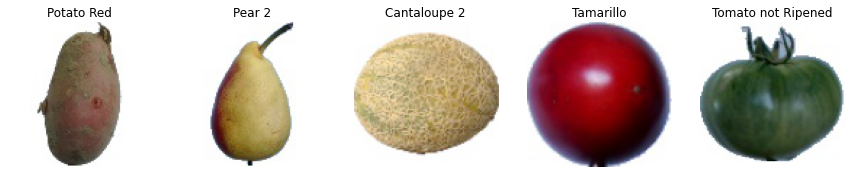

In [129]:
#generate example batch
#torch.manual_seed(7)
np.random.seed(4)

pl_model.train()

initial_pics = example_batch[0]
correct_classes = example_batch[1]

#either model aug (augerino-learned), or standalone
#with torch.no_grad():
augmented = custom_aug(initial_pics)

subsample = np.random.randint(batch_size, size=5)

fig, ax = plt.subplots(1, 5, figsize=(15, 10))
for i, img_idx in enumerate(subsample):
    ax[i].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
    ax[i].set_title(class_names[correct_classes[img_idx].item()])
    ax[i].axis('off')
plt.show()

In [130]:
#как модель работает на примере (до аугментаций)
pl_model.eval()
with torch.no_grad():
    model_output = pl_model.model(initial_pics)
    neg_logs = F.log_softmax(model_output, dim=1)
    probs = torch.exp(neg_logs)
    final_preds = torch.argmax(probs, dim=1)

hit_mask = (final_preds == correct_classes)
acc = hit_mask.float().mean()

print(final_preds, correct_classes)
print('accuracy: ', acc)

tensor([ 71, 128,  74, 122, 118, 118,  41,  14, 120, 117,  15,  27,  86,  42,
         84,  30,  42, 105,  95, 114,  41,  12, 130,  23, 104, 107, 107, 106,
         32, 103,  36,  30]) tensor([ 53, 128,  74, 122, 118, 118,  41,  14, 120, 117,  15,  27,  86,  42,
         84,  30,  42, 105,  95, 114,  41,  12, 130,  23, 104, 107, 107, 106,
         32, 103,  36,  30])
accuracy:  tensor(0.9688)


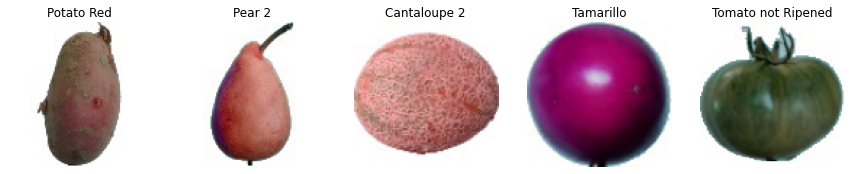

In [131]:
#аугментации
pl_model.train()
with torch.no_grad():

    fig, ax = plt.subplots(1, 5, figsize=(15, 10))

    for i, img_idx in enumerate(subsample):
        ax[i].imshow(torch.clamp((augmented[img_idx]), 0, 1).permute(1, 2, 0))
        ax[i].set_title(class_names[correct_classes[img_idx].item()])
        ax[i].axis('off')
    plt.show()

In [132]:
#какой результат модель показывает на аугментации
pl_model.train()
with torch.no_grad():
    model_output_aug = pl_model.model(augmented)
    neg_logs_aug = F.log_softmax(model_output_aug, dim=1)
    probs_aug = torch.exp(neg_logs_aug)
    final_preds_aug = torch.argmax(probs_aug, dim=1)

hit_mask_aug = (final_preds_aug == correct_classes)
acc_aug = hit_mask_aug.float().mean()

print(final_preds_aug, correct_classes)
print('accuracy: ', acc_aug)

tensor([110, 128, 128,  94,  39, 105,  37,  14, 120, 117,  15,  27,  92,  36,
         84, 124,  42,  59,  95,  48,  21,  95,  64,  60,  32, 107,  73, 106,
         32, 103,  36,  30]) tensor([ 53, 128,  74, 122, 118, 118,  41,  14, 120, 117,  15,  27,  86,  42,
         84,  30,  42, 105,  95, 114,  41,  12, 130,  23, 104, 107, 107, 106,
         32, 103,  36,  30])
accuracy:  tensor(0.4688)


In [133]:
#pictures where non-augged model got it right
non_aug_got_right = np.where((hit_mask == True).int() * np.arange(batch_size)!=0)[0]
#pictures where augged model got it wrong
aug_got_right = np.where((hit_mask_aug == True).int() * np.arange(batch_size)!=0)[0]
#pictures where non-augged got it right, but augged got it wrong
print(non_aug_got_right, aug_got_right)
no_problem = np.intersect1d(non_aug_got_right, aug_got_right)
no_problem

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] [ 1  7  8  9 10 11 14 16 18 25 27 28 29 30 31]


array([ 1,  7,  8,  9, 10, 11, 14, 16, 18, 25, 27, 28, 29, 30, 31])

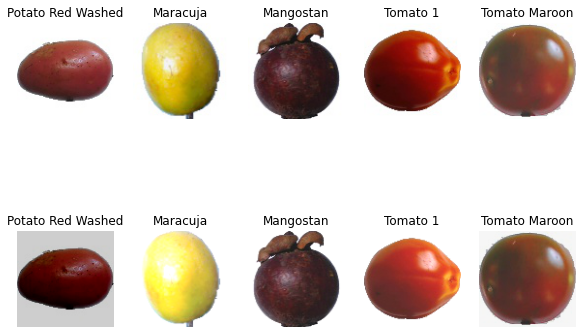

In [82]:
#какие аугментации не мешают модели
pl_model.eval()
with torch.no_grad():

    fig, ax = plt.subplots(2, 5, figsize=(10, 7))

    for j, img_idx in enumerate(no_problem[:5]):
        ax[0][j].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
        ax[0][j].set_title(class_names[final_preds[img_idx].item()])
        ax[0][j].axis('off')
        ax[1][j].imshow(torch.clamp((augmented[img_idx]), 0, 1).permute(1, 2, 0))
        ax[1][j].set_title(class_names[final_preds_aug[img_idx].item()])
        ax[1][j].axis('off')
    plt.show()

In [135]:
#pictures where non-augged model got it right
non_aug_got_right = np.where((hit_mask == True).int() * np.arange(batch_size)!=0)[0]
#pictures where augged model got it wrong
aug_got_wrong = np.where((hit_mask_aug == False).int() * np.arange(batch_size)!=0)[0]
#pictures where non-augged got it right, but augged got it wrong
print(non_aug_got_right, aug_got_wrong)
confused = np.intersect1d(non_aug_got_right, aug_got_wrong)
confused

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] [ 2  3  4  5  6 12 13 15 17 19 20 21 22 23 24 26]


array([ 2,  3,  4,  5,  6, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 26])

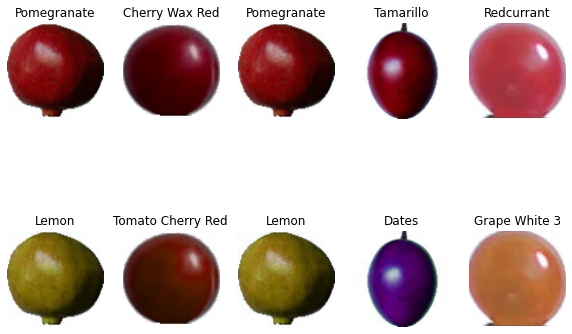

In [136]:
#viz where aug confused
pl_model.eval()
with torch.no_grad():
    
    if len(confused) > 5:
        confused_subsample = confused[np.random.randint(len(confused), size=5)]
    else:
        confused_subsample = confused

    fig, ax = plt.subplots(2, len(confused_subsample), figsize=(10, 7))

    for j, img_idx in enumerate(confused_subsample):
        ax[0][j].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
        ax[0][j].set_title(class_names[final_preds[img_idx].item()])
        ax[0][j].axis('off')
        ax[1][j].imshow(torch.clamp((augmented[img_idx]), 0, 1).permute(1, 2, 0))
        ax[1][j].set_title(class_names[final_preds_aug[img_idx].item()])
        ax[1][j].axis('off')
    plt.show()

In [141]:
#invariant
#pictures where non-augged model got it right
non_aug_got_right = np.where((hit_mask == True).int() * np.arange(batch_size)!=0)[0]
#pictures where augged model got it right all the same
aug_got_right = np.where((hit_mask_aug == True).int() * np.arange(batch_size)!=0)[0]
#pictures with invariance
print(non_aug_got_right, aug_got_right)
invariant = np.intersect1d(non_aug_got_right, aug_got_right)
invariant

[ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31] [ 1  2  4  5  6  7  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25 26 29 31]


array([ 1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 24, 25, 26, 29, 31])

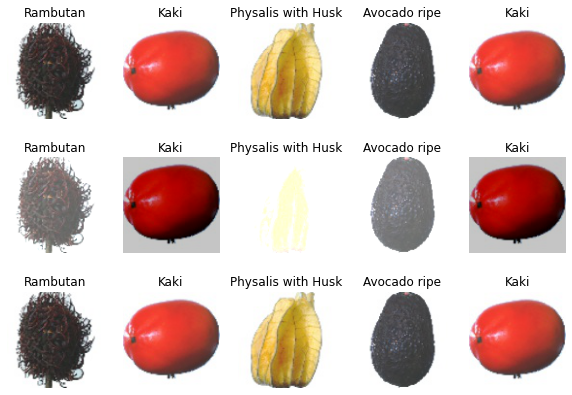

In [142]:
#viz where invariant
pl_model.eval()
with torch.no_grad():
    
    if len(invariant) > 5:
        invariant_subsample = invariant[np.random.randint(len(invariant), size=5)]
    else:
        invariant_subsample = invariant

    fig, ax = plt.subplots(3, len(invariant_subsample), figsize=(10, 7))

    for j, img_idx in enumerate(invariant_subsample):
        ax[0][j].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
        ax[0][j].set_title(class_names[final_preds[img_idx].item()])
        ax[0][j].axis('off')
        ax[1][j].imshow(torch.clamp((augmented[img_idx]), 0, 1).permute(1, 2, 0))
        ax[1][j].set_title(class_names[final_preds_aug[img_idx].item()])
        ax[1][j].axis('off')
        ax[2][j].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
        ax[2][j].set_title(class_names[correct_classes[img_idx].item()])
        ax[2][j].axis('off')
    plt.show()

In [404]:
#viz where augmentation surprisingly helped (or maybe not? otherwise, why the case for TTA)
#pictures where non-augged model got it wrong
non_aug_got_wrong = np.where((hit_mask == False).int() * np.arange(batch_size)!=0)[0]
#pictures where augged model got it right
aug_got_right = np.where((hit_mask_aug == True).int() * np.arange(batch_size)!=0)[0]
#pictures where augmentation helped
print(non_aug_got_wrong, aug_got_right)
helped = np.intersect1d(non_aug_got_wrong, aug_got_right)
helped

[ 1  2 23 24 30] [ 4  5  6  7  8 10 11 12 14 15 16 17 18 19 20 21 22 25 26 27 28 29 31]


array([], dtype=int64)

In [ ]:
#viz where helped
pl_model.eval()
with torch.no_grad():
    
    if len(helped) > 5:
        helped_subsample = helped[np.random.randint(len(helped), size=5)]
    else:
        helped_subsample = helped

    fig, ax = plt.subplots(2, len(helped_subsample), figsize=(10, 7))

    for j, img_idx in enumerate(helped_subsample):
        ax[0][j].imshow(torch.clamp((initial_pics[img_idx]), 0, 1).permute(1, 2, 0))
        ax[0][j].set_title(class_names[final_preds[img_idx].item()])
        ax[0][j].axis('off')
        ax[1][j].imshow(torch.clamp((augmented[img_idx]), 0, 1).permute(1, 2, 0))
        ax[1][j].set_title(class_names[final_preds_aug[img_idx].item()])
        ax[1][j].axis('off')
    plt.show()

In [249]:
#range of invariance
inv_range = hue_aug.lims
inv_range

tensor([-6.2831,  6.2831], grad_fn=<MulBackward0>)

In [256]:
inv_range = model.aug.log_lims
inv_range

Parameter containing:
tensor([-12.5284,  12.5315], requires_grad=True)